# **Uber Forecasting with Machine Learning**

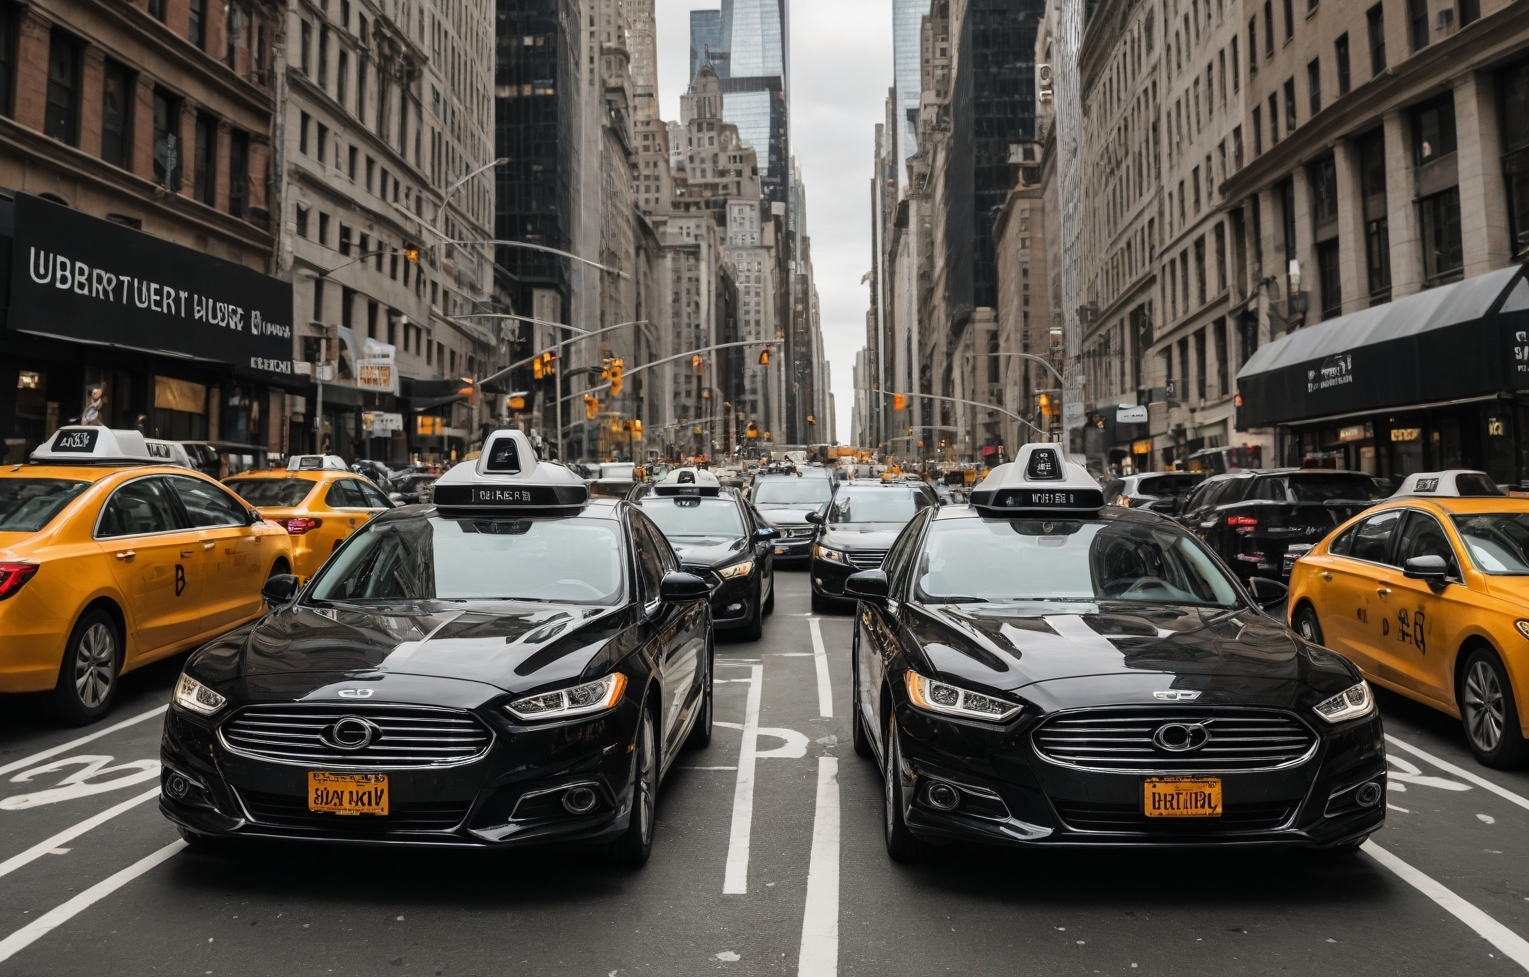

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, json
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from IPython.display import IFrame
import os
import gc

In [ ]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing aprsep_14 from Drive
aprsep_14 = pd.read_pickle('/content/drive/My Drive/I_Xperience2024-2-Uber-Ride-Analysis/data/aprsep_14.pkl')

---
# Random Forest Regression to Predict Uber Demand by Time of Day and Location

Fitting a linear regression to the date, time, and location to predict the amount of vehicles that would be necessary in that area at that time.

In [ ]:
# Making a new dataset that groups by location.

def LocationGroupingFunction(DataFrame, Latitude:str, Longitude:str, DivPerDim:int = 10):
  LocationGroup:list = []

  LatitudeMax = DataFrame[Latitude].max()
  LatitudeMin = DataFrame[Latitude].min()
  LongitudeMax = DataFrame[Longitude].max()
  LongitudeMin = DataFrame[Longitude].min()

  LatitudeRange = (LatitudeMax - LatitudeMin)
  LongitudeRange = (LongitudeMax - LongitudeMin)
  LatitudeDivisionSize = LatitudeRange / DivPerDim
  LongitudeDivisionSize = LongitudeRange / DivPerDim

  for Lat, Lon in zip(DataFrame[Latitude],DataFrame[Longitude]):
    LatVal = abs(math.floor(float(Lat - LatitudeMin)/LatitudeDivisionSize))
    LonVal = abs(math.floor(float(Lon - LongitudeMin)/LongitudeDivisionSize))
    LocationGroup.append(LatVal*10**math.floor(math.log10(DivPerDim))+LonVal)

  return LocationGroup

In [ ]:
LinearData = aprsep_14.copy()
LinearData["date"] = LinearData.date_time.dt.date
# LinearData.base, Bases = LinearData.base.factorize()
# LinearData.month, Months = LinearData.month.factorize()
# LinearData.weekday, Weekdays = LinearData.weekday.factorize()

LinearData['group'] = LocationGroupingFunction(LinearData, "lat", "lon", DivPerDim = 100)

LinearData = LinearData.groupby(["date", "group", 'month', 'day','hour']).size().reset_index(name = "pickups")

In [ ]:
DummyData = pd.get_dummies(LinearData, columns = ['month'])
DummyData.columns

Index(['date', 'group', 'day', 'hour', 'pickups', 'month_April',
       'month_August', 'month_July', 'month_June', 'month_May',
       'month_September'],
      dtype='object')

In [ ]:
Regressor = RandomForestRegressor(n_jobs=-1)

Scaler = StandardScaler()

X = Scaler.fit_transform(DummyData.drop(["pickups", 'date'], axis = 1)[['group', 'day', 'hour']])
X = pd.concat([pd.DataFrame(X, columns = ['group', 'day', 'hour']), DummyData.drop(["pickups", 'date'], axis = 1)[['month_April', 'month_May', 'month_June', 'month_July', 'month_August', 'month_September']]], axis = 1)
Y = LinearData["pickups"]

In [ ]:
Principle = PCA(n_components=9)

PcaScores = pd.DataFrame(Principle.fit_transform(X), columns = ['PC' + str(i) for i in range(1, 10)])

PcaComponents = pd.DataFrame(Principle.components_[0:3], columns = X.columns)
KeepFeatures = PcaComponents.describe().T[PcaComponents.abs().describe().T['max'] >= 0.5].index
KeepFeatures

Index(['group', 'day', 'hour'], dtype='object')

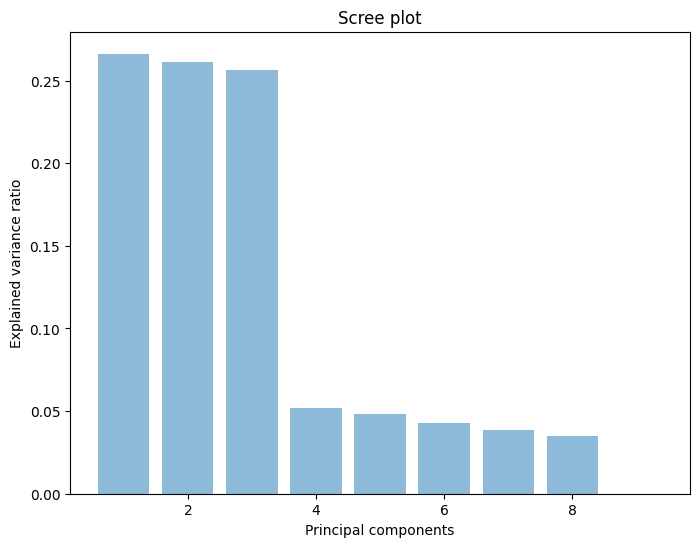

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(Principle.explained_variance_ratio_) + 1), Principle.explained_variance_ratio_, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Scree plot')
plt.show()

In [ ]:
CorrectHours = train_test_split(DummyData.hour, Y, test_size=0.3, random_state=2002)[1]
CorrectDays = train_test_split(DummyData.day, Y, test_size=0.3, random_state=2002)[1]
CorrectMonths = train_test_split(LinearData.month, Y, test_size=0.3, random_state=2002)[1]
CorrectMonths = CorrectMonths.replace({0: 'April', 1: 'May', 2: 'June', 3: 'July', 4: 'August', 5: 'September'})

XTrain, XTest, YTrain, YTest = train_test_split(X[['group', 'day', 'hour', 'month_April', 'month_May', 'month_June', 'month_July', 'month_August', 'month_September']], Y, test_size=0.3, random_state=2002)

Regressor.fit(XTrain, YTrain)

RandomForestRegressor(n_jobs=-1)

In [ ]:
PredictedRequirements = Regressor.predict(XTest)

print(f"R2: {r2_score(YTest, PredictedRequirements)}")
print(f"MSE: {mean_squared_error(YTest, PredictedRequirements)}")
print(f"RMSE: {np.sqrt(mean_squared_error(YTest, PredictedRequirements))}")

print(f"Max: {YTest.max()} and min: {YTest.min()}")

R2: 0.9095881673481947
MSE: 218.92552404003743
RMSE: 14.796132063483261
Max: 1089 and min: 1


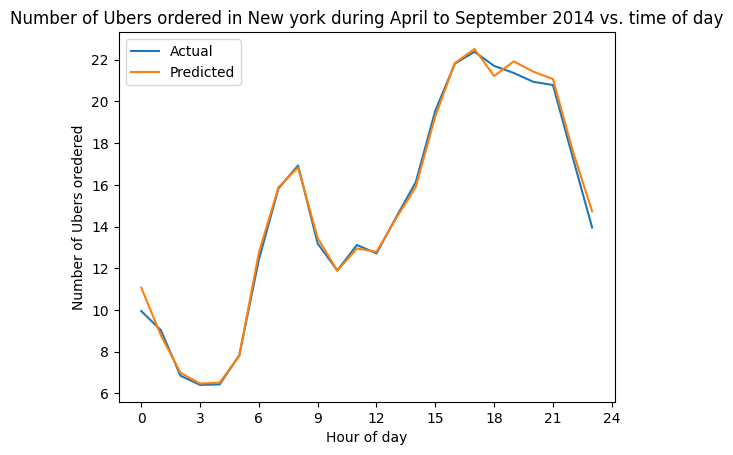

In [ ]:
#Ploting the Actual data against the predictive data.
plt.figure()
sns.lineplot(x = CorrectHours, y = YTest, errorbar = None)
sns.lineplot(x = CorrectHours, y = PredictedRequirements, errorbar = None)
plt.title("Number of Ubers ordered in New york during April to September 2014 vs. time of day")
plt.xlabel("Hour of day")
plt.ylabel("Number of Ubers oredered")
plt.legend(['Actual', 'Predicted'])
plt.xticks(range(0,25, 3))
plt.show()

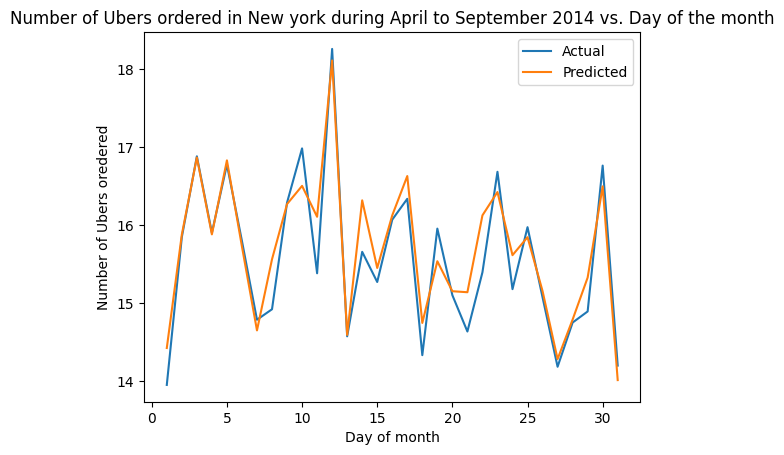

In [ ]:
plt.figure()
sns.lineplot(x = CorrectDays, y = YTest, errorbar = None)
sns.lineplot(x = CorrectDays, y = PredictedRequirements, errorbar = None)
plt.title("Number of Ubers ordered in New york during April to September 2014 vs. Day of the month")
plt.xlabel("Day of month")
plt.ylabel("Number of Ubers oredered")
plt.legend(['Actual', 'Predicted'])
plt.show()

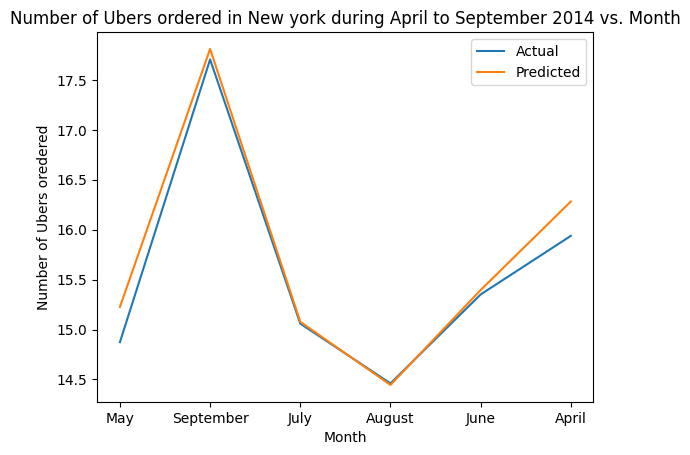

In [ ]:
plt.figure()
sns.lineplot(x = CorrectMonths, y = YTest, errorbar = None)
sns.lineplot(x = CorrectMonths, y = PredictedRequirements, errorbar = None)
plt.title("Number of Ubers ordered in New york during April to September 2014 vs. Month")
plt.xlabel("Month")
plt.ylabel("Number of Ubers oredered")
plt.legend(['Actual', 'Predicted'])
plt.show()